In [1]:
#import
import sys
from enum import Enum
import itertools
import pygame
import snakes.plugins
from sortedcontainers import SortedList, SortedSet, SortedDict
snakes.plugins.load('gv', 'snakes.nets', 'nets')
from nets import *
# just for the notebook
from IPython.display import Image
import pandas as pd

In [2]:
class Relations(Enum):
	SUCCESSIONS     = '>'
	RIGHT_CAUSALITY = '->'
	LEFT_CAUSALITY  = '<-'
	PARALLEL        = '||'
	CHOICES         = '#'

In [3]:
# class representing Alpha miner
# Alpha Miner class
class AlphaMiner:

	def __init__(self,Traces):
		# Traces within an event log
		self.traces = Traces
		# set of transition a.k.a activities or T
		self.transitions = SortedSet()
		# set of initial transitions Ti
		self.initial_transitions = SortedSet()
		# set of final transitions To
		self.final_transitions = SortedSet()
		# set of pairs (A,B)  Xl
		self.pairs = []
		# set of maximal pairs (A,B) Yl
		self.maxi_pairs = []
		# set of p(A,B) between maxi_pairs Pl
		self.places = []
		# Footprint , relations between activities
		self.relations = SortedDict()
		#Petri NET
		self.PetriNet = None
	def getTransitions(self):
		#Lemme 1
		for trace in self.traces.values():
			for activity in trace:
				self.transitions.add(activity)
		return self.transitions
	def getInitialTransitions(self):
		# Lemme 2
		#For each trace get the first activity 
		#and add it to a set of initial transitions
		for trace in self.traces.values():
			print(trace[0])
			self.initial_transitions.add(trace[0])
		return self.initial_transitions;
	def getFinalTransitions(self):
		#For each trace get the first activity 
		#and add it to a set of initial transitions
		for trace in self.traces.values():
			print(trace[len(trace)-1])
			self.final_transitions.add(trace[len(trace)-1])
		return self.final_transitions
		
	def extractRelations(self):
		
		

		#Extract non repetitive traces, alpha dont take care  about  frequencies !
		nnrep_traces = SortedSet()
		for trace in self.traces.values():
			nnrep_traces.add("".join(trace))
		print(nnrep_traces)
		#Extract relations between each transitions
		# generate Footprint
		for transition1 in self.transitions:
			self.relations[transition1] = SortedDict()
			for transition2 in self.transitions:
				concat = transition1+transition2
				print(concat)
				relation = None
				for trace in nnrep_traces:
					
					if trace.find(concat) >= 0:
						#Causality
						print(concat)
						if  relation == Relations.LEFT_CAUSALITY:
							relation = Relations.PARALLEL
						else:
							relation = Relations.RIGHT_CAUSALITY

					if trace.find(concat[::-1]) >= 0:
						print(concat[::-1])
						if relation == Relations.RIGHT_CAUSALITY:
							relation = Relations.PARALLEL
						else:
							relation = Relations.LEFT_CAUSALITY
				if relation == None:
					relation = Relations.CHOICES
				self.relations[transition1][transition2] = relation


		return self.relations
	def computePairs(self):
		# extract pairs of set , each set contain activities 
		#that doesnt have any relation between them and the activities in the two set have to be direcly successed by each other 
		#Lemme 4
	    pairs_causality = []
	    pairs_choices = []
	    pairs = []
	    #Extract all possible pairs of activity with causality relation
	    for activity1 ,relations1 in self.relations.items():
	    	for activity2 , relation in relations1.items():
	    		if relation == Relations.RIGHT_CAUSALITY :
	    			pairs_causality.append((activity1,activity2))
	    		if relation == Relations.CHOICES:
	    			if activity1 == activity2:
	    				pairs_choices.append((activity1,))
	    			else:
	    				pairs_choices.append((activity1,activity2))

	    print(pairs_causality)
	    pairs= pairs_causality
	    print(pairs_choices)

	    #  find all possible sets of activity with causality relation
	    #  
	    i = 0
	    j = len(pairs_choices)

	    while i < j :
	    	seti = pairs_choices[i]
	    	for pair in pairs_choices:
	    		union = True
	    		if len(SortedSet(seti).intersection(SortedSet(pair))) != 0:
	    			for e1 in pair:
	    				if union == False:
	    					break
	    				for e2 in seti:
	    					if self.relations[e1][e2] != Relations.CHOICES:
	    						union = False
	    						break
	    			if union :
	    				new_pair = SortedSet(seti) | SortedSet(pair) 
	    				if tuple(new_pair) not in pairs_choices:
	    					pairs_choices.append(tuple(new_pair))
	    					j = j + 1
	    					#Reevaluate the length
	    		
	    	i = i + 1

	    print(pairs_choices)

	    # Union 
	    for pair_choices1 in pairs_choices:
	    	for pair_choices2 in pairs_choices:
	    		relation_between_pair = None
	    		makePair = True
	    		print("pair 1",pair_choices1)
	    		print("pair 2",pair_choices2)
	    		intersection = SortedSet(pair_choices1).intersection(pair_choices2)
	    		pair_choices2 = SortedSet(pair_choices2)
	    		if len(intersection) != 0 :
	    			# remove intersection terms in the second pair
	    			for term in intersection:
	    				pair_choices2.discard(term)
                  
	    		if(len(pair_choices2) == 0):
	    			continue
	    		pair_choices2= tuple(pair_choices2)
	    		print("pair_choices2 with discarded term :",pair_choices2)

	    		for activity1 in pair_choices1:
	    			print(activity1)
	    			if makePair == False:
	    				break
	    			for activity2 in pair_choices2:
	    				print(activity2)
	    				relation = self.relations[activity1][activity2]
	    				if relation_between_pair != None and relation_between_pair != relation:
	    					makePair = False
	    					break
	    				else:
	    					relation_between_pair = relation
	    				if relation != Relations.RIGHT_CAUSALITY:
	    					makePair = False
	    					break
	    		if makePair == True:
	    			print("makepair true")
	    			print(pair_choices1)
	    			print(pair_choices2)
	    			if relation_between_pair == Relations.RIGHT_CAUSALITY:
	    				new_pair = (pair_choices1,pair_choices2)
	    			else:
	    				new_pair = (pair_choices2,pair_choices1)
	    			pairs.append(new_pair)
	    print("\n")
	    print("\n")
	    print(pairs)
	    self.pairs = pairs



	    		

	    '''
		combinations = list(itertools.combinations(list(self.transitions),len(self.transitions)))
		possible_successions = SortedSet() 
		for combination in combinations:
			combination = "".join(combination)
			possible_successions.add(combination)
		print(possible_successions)'''

	def extract_maximal_pairs(self):
		pos1 =0
		pair_appended = []
		maxi_pairs = []
		for pair1 in self.pairs:
			append = True
			# flat the pair 1
			flat_pair1 = []
			for s in pair1:
				for e in s:
					flat_pair1.append(e)
			print("pair1 :",pair1)
			print("flat_pair1 :",flat_pair1)
			pos2 = 0
			for pair2 in self.pairs:
				if pos1 != pos2:
					flat_pair2 = []
					for s in pair2:
						for e in s:
							flat_pair2.append(e)
					print("pair2 :",pair2)
					print("flat_pair2 :",flat_pair2)
					# flat the pair 1

					# flat the pair 2
					# check if pair1 issubset of pair 2 or pair 2 is subset of 1
					if SortedSet(flat_pair1).issubset(flat_pair2) and SortedSet(flat_pair1)!= SortedSet(flat_pair2):
						print("issubset")
						append = False
				pos2 = pos2 + 1

			if append == True:

				print("append")
				if SortedSet(flat_pair1) not in pair_appended:
					maxi_pairs.append(pair1)
					pair_appended.append(SortedSet(flat_pair1))
			pos1 = pos1 + 1
		print(maxi_pairs)
		self.maxi_pairs = maxi_pairs



		#Lemme 5
		pass
	def add_places(self):
		#Lemme 6

		# connect initial transition with place
		cpt = 0
		self.places.append(("P"+str(cpt),self.initial_transitions))
		cpt = 1  
		for pair in self.maxi_pairs:
			self.places.append((pair[0],"P"+str(cpt),pair[1]))
			cpt+=1
		self.places.append((self.final_transitions,"P"+str(cpt)))
		print(self.places)

	def extract_PetriNet(self):
		n = PetriNet('N')
		n.add_place(Place('p'+str(0)))
		cpt_p = 1
		for pair in self.maxi_pairs:
			n.add_place(Place('p'+str(cpt_p)))
			cpt_p += 1
		n.add_place(Place('p'+str(cpt_p)))
		for transition in self.transitions:
			n.add_transition(Transition(transition))
		print(self.initial_transitions)
		for transition in self.initial_transitions:
			n.add_input('p'+str(0),transition,Value(dot))
		cpt_p = 1
		for pair in self.maxi_pairs:
			#pair[0] produce
			#pair[1] consume
			for transition in pair[0]:
				n.add_output('p'+str(cpt_p), transition,Value(dot))
			for transition in pair[1]:
				n.add_input('p'+str(cpt_p), transition,Value(dot))
			cpt_p+=1
		for transition in self.final_transitions:
			n.add_output('p'+str(cpt_p),transition,Value(dot))
		self.PetriNet = n

	def show(self,model = None):

			def draw_place (place, attr) :
				attr['label'] = place.name.upper()
				attr['color'] = '#FF0000'
			def draw_transition (trans, attr) :
				if str(trans.guard) == 'True' :
					attr['label'] = trans.name
				else :
					attr['label'] = '%s\n%s' % (trans.name, trans.guard)
			self.PetriNet.draw(',net-with-colors.png',place_attr=draw_place, trans_attr=draw_transition)
			'''import pygame
			pygame.init()

			size = width, height = 1200, 682
			WHITE = (255, 255, 255)


			screen = pygame.display.set_mode(size)
			screen.fill(WHITE)
			pygame.display.set_caption("petri net alphaminer")

			petri_net = pygame.image.load(",net-with-colors.png").convert()
			surf = pygame.transform.rotate(petri_net, 90)
			screen.blit(surf, (50, 0))

			pygame.display.flip()
			while True:
				for e in pygame.event.get():
					if e.type == pygame.QUIT or (e.type == pygame.KEYDOWN and e.key == pygame.K_ESCAPE):
						done = True
						break'''

In [4]:
# testing
with open("log.csv","r") as my_file :
	traces = SortedDict()
	contenu = my_file.read()
	events =contenu.split("\n")
	for event in events:
		case_id,activity = event.split(',')
		if case_id not in traces:
			traces[case_id] = []

		traces[case_id].append(activity)
	print(traces)


Alph = AlphaMiner(traces)

print(Alph.getInitialTransitions())
print(Alph.getFinalTransitions())
print(Alph.getTransitions())
print(Alph.extractRelations())

print(Alph.computePairs())
print(Alph.extract_maximal_pairs())
print(Alph.add_places())
Alph.extract_PetriNet()
print(Alph.show(model = "petrinet"))

FileNotFoundError: [Errno 2] No such file or directory: 'log.csv'

In [18]:
print(Alph.traces)

SortedDict(None, 1000, {'1': ['a', 'b', 'e', 'f'], '2': ['a', 'b', 'c', 'e', 'd', 'b', 'f'], '3': ['a', 'b', 'e', 'c', 'd', 'b', 'f'], '4': ['a', 'b', 'c', 'd', 'e', 'b', 'f'], '5': ['a', 'e', 'b', 'c', 'd', 'b', 'f']})


In [19]:
pd.DataFrame.from_dict(Alph.relations, orient="index")

,a,b,c,d,e,f
a,Relations.CHOICES,Relations.RIGHT_CAUSALITY,Relations.CHOICES,Relations.CHOICES,Relations.RIGHT_CAUSALITY,Relations.CHOICES
b,Relations.LEFT_CAUSALITY,Relations.CHOICES,Relations.RIGHT_CAUSALITY,Relations.LEFT_CAUSALITY,Relations.PARALLEL,Relations.RIGHT_CAUSALITY
c,Relations.CHOICES,Relations.LEFT_CAUSALITY,Relations.CHOICES,Relations.RIGHT_CAUSALITY,Relations.PARALLEL,Relations.CHOICES
d,Relations.CHOICES,Relations.RIGHT_CAUSALITY,Relations.LEFT_CAUSALITY,Relations.CHOICES,Relations.PARALLEL,Relations.CHOICES
e,Relations.LEFT_CAUSALITY,Relations.PARALLEL,Relations.PARALLEL,Relations.PARALLEL,Relations.CHOICES,Relations.RIGHT_CAUSALITY
f,Relations.CHOICES,Relations.LEFT_CAUSALITY,Relations.CHOICES,Relations.CHOICES,Relations.LEFT_CAUSALITY,Relations.CHOICES


In [20]:
print(Alph.pairs)

[('a', 'b'), ('a', 'e'), ('b', 'c'), ('b', 'f'), ('c', 'd'), ('d', 'b'), ('e', 'f'), (('a',), ('b',)), (('a',), ('e',)), (('a', 'd'), ('b',)), (('b',), ('c',)), (('b',), ('c', 'f')), (('b',), ('c', 'f')), (('b',), ('f',)), (('c',), ('d',)), (('d', 'a'), ('b',)), (('d',), ('b',)), (('e',), ('f',))]


In [21]:
print(Alph.maxi_pairs)

[('a', 'e'), ('c', 'd'), ('e', 'f'), (('a', 'd'), ('b',)), (('b',), ('c', 'f'))]


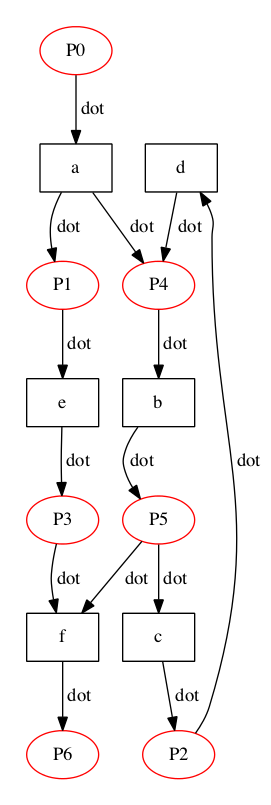

In [22]:
Image(',net-with-colors.png')